In [6]:
import yfinance as yf
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta
import numpy as np
from plotnine import ggplot, geom_line, aes, theme_minimal, geom_tile, geom_label,\
                     scale_fill_distiller, labs, theme, element_text

In [7]:
def makeLongTimeSeriesDf(timeSeriesDataFrame):
    return timeSeriesDataFrame.reset_index().melt(id_vars = 'Date').copy()

def makeTimeSeriesPlot(title,longTimeSeriesDataFrame):
    myPlot =  (
        ggplot(longTimeSeriesDataFrame.dropna(subset=["value"]))  
        + aes(x="Date", y="value",color = "Ticker")  
        + geom_line()  # Geometric object to use for drawing
        + labs(
            x = 'Date', 
            y = 'Share Price', 
            color = 'Tickers', 
            title = title)
        + theme(axis_text_x = element_text(rotation = 90, hjust = 0), figure_size = (10,6))
    )
    return myPlot

In [8]:
tickers = ['GOOG', 'NVDA','META','EQX']

today = dt.date.today()
holding = today - dt.timedelta(weeks=4)
lookback = holding - relativedelta(years=10)


dataLookbackFull = yf.download(tickers, start=lookback, end=holding, auto_adjust=True)['Close']
dataLookbackNoNa = dataLookbackFull.dropna(subset=["EQX"]).copy()
dataHolding = yf.download(tickers, start=holding, end=today, auto_adjust=True)['Close']

[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed


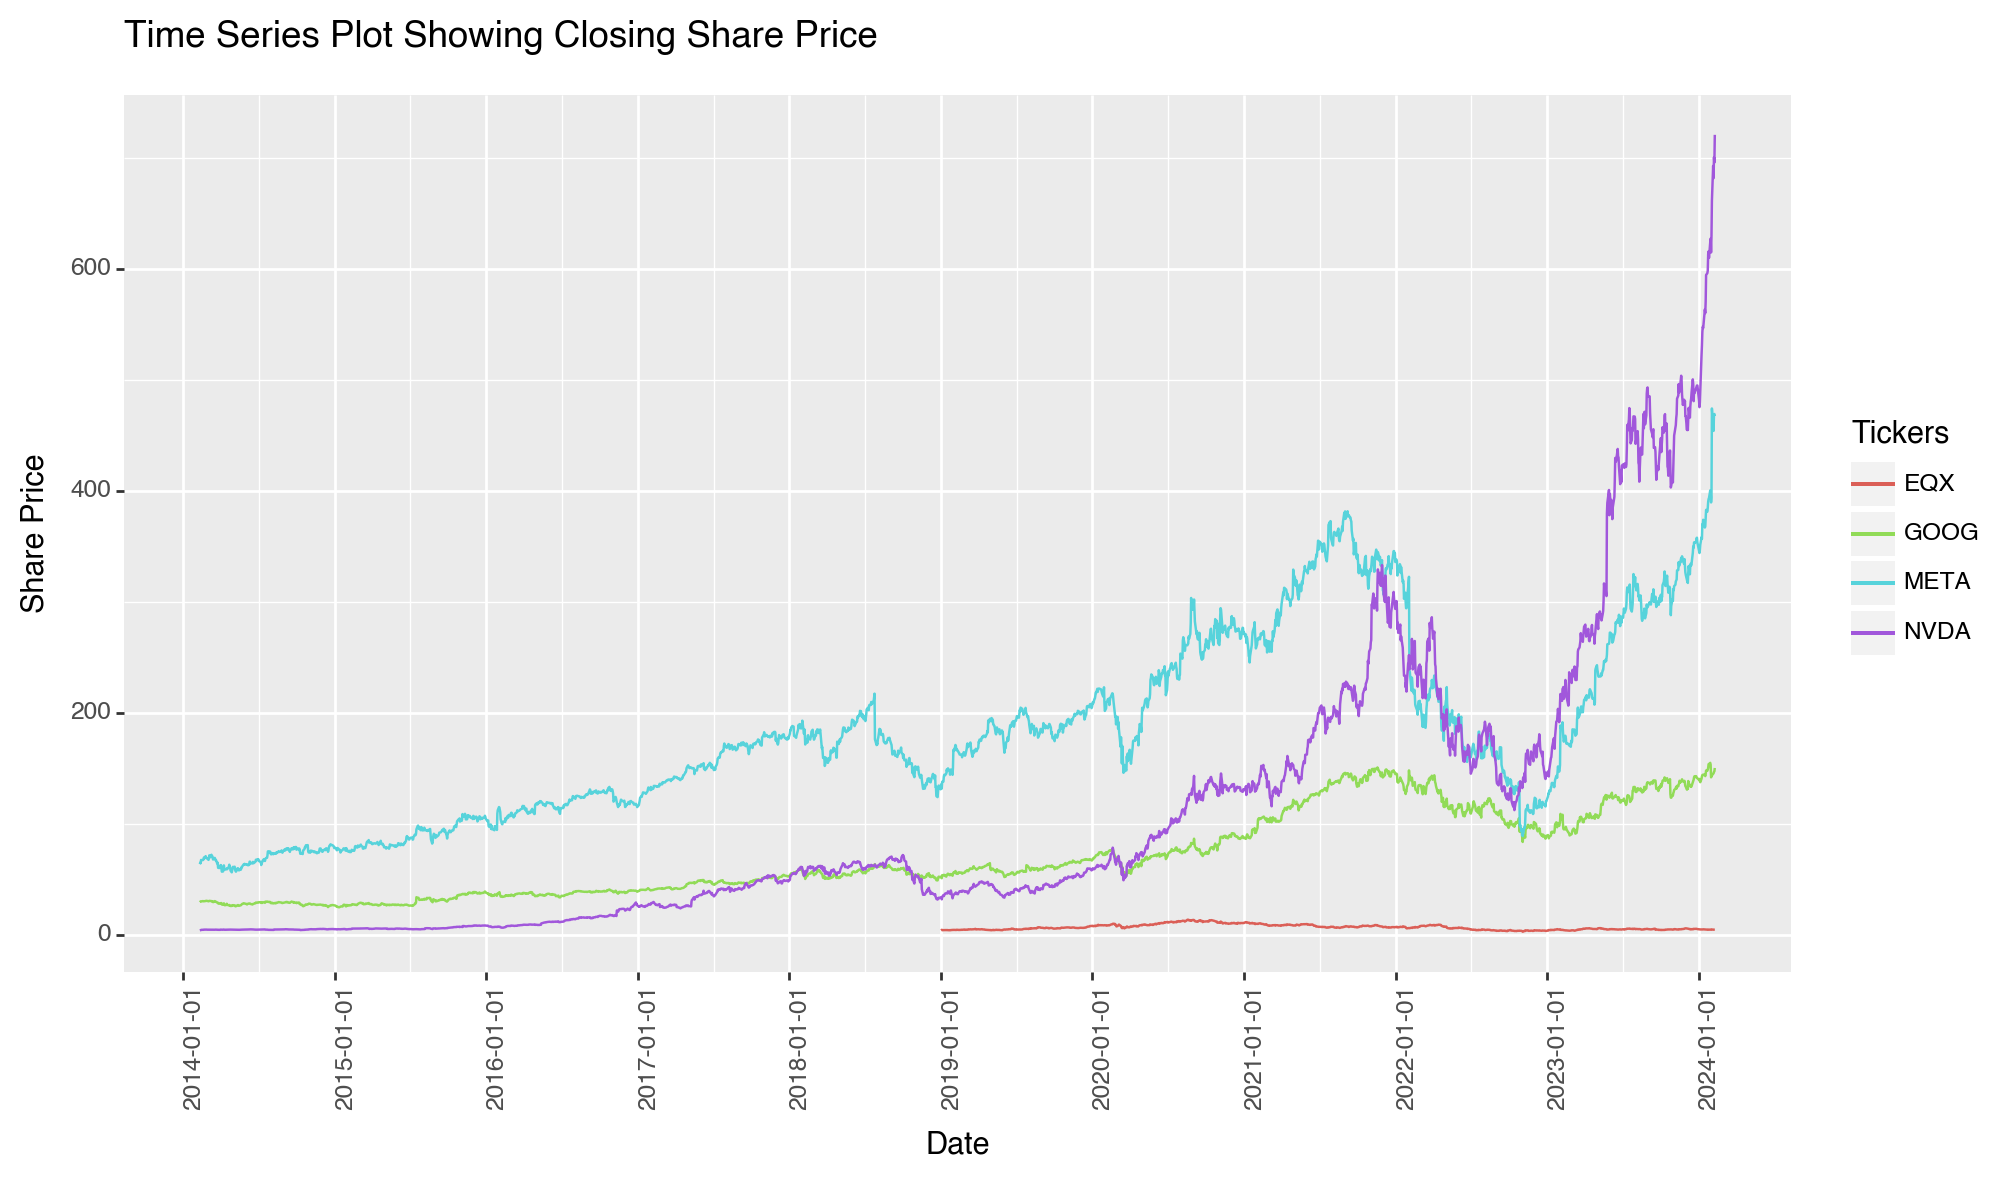

<Figure Size: (1000 x 600)>

In [9]:
df = makeLongTimeSeriesDf(dataLookbackFull)
makeTimeSeriesPlot('Time Series Plot Showing Closing Share Price Before Data Imputation',df)

In [10]:
# We can need to take into account the correlations between the other assets in our portfolio when 
# We do imputation i.e. Multivariate time series imputation. One could use Vector Auto Regressive 
# Model. This is a regression that fits the entire time series and considers cross correlations
# In order to use VAR models, we would need to make all our time series stationery before we could
# Implement them. Hesitant to use a recurrent neural network (or any neural network) given the 
# their black box nature. Spatio-temporal factoring methods could be good here. There is a good 
# Python implementaion of Multivariate Singular Spectrum Analysis (mSSA). The spatial component 
# is the correlation across all the time series. Hoping that this can capture how the correlation 
# changes over time - markets tend to be more correlated during periods of market stress. Another 
# is that mSSA requires less prep time to make it work - VAR method must ensure that time series is 
# an autoregressive process via transformations. VAR just seems like a lot of work for an interview
# question. Will investigate all possible methods a later date when I have time. 

In [11]:
from mssa.mssa import mSSA